## Import Statements

In [1]:
import copy
import sys

import numpy as np
import pandas as pd
from PIL import Image

sys.path.append('../Mendota/')
import resnet

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, 
                             accuracy_score, balanced_accuracy_score)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data_utils
import torch.optim as optim
from torchvision import transforms

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import seaborn as sns

pd.options.mode.chained_assignment = None
# np.random.seed(0)

## Read in Data

In [2]:
data = pd.read_json('../Data/data.json')
labels = data[['label']]
data = data.drop('label', axis='columns')

## Add Features

In [3]:
data['log_turbidity'] = np.log(data['turbidity'] + 1)

## Feature Correlation

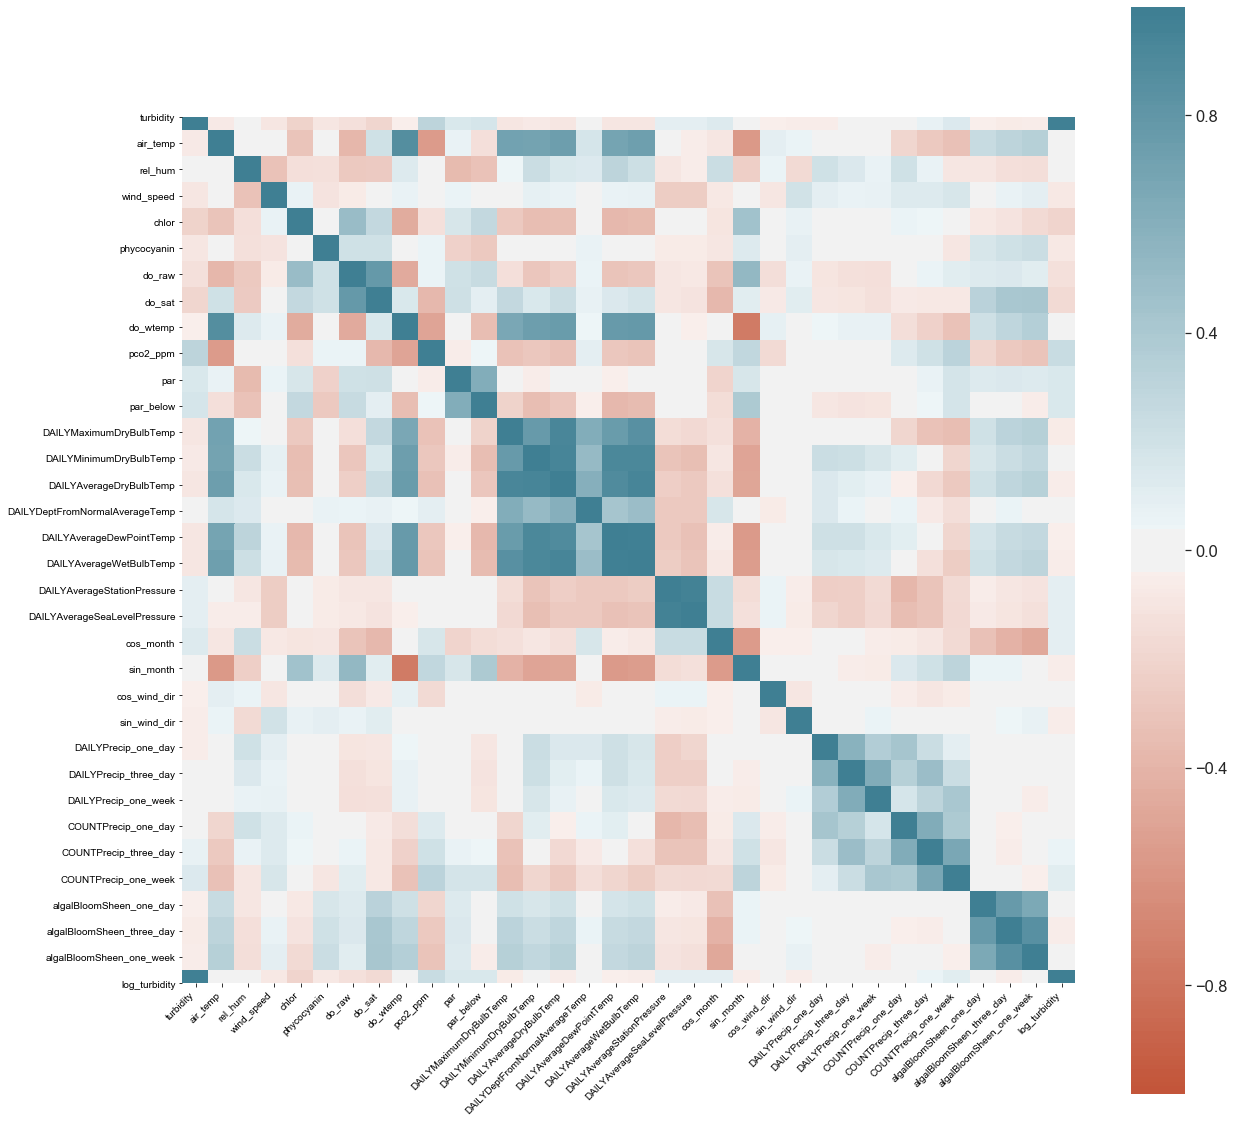

In [4]:
corr = data.corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Choose Correlated Features to Remove

Removed features: 
	 log_turbidity
	 do_wtemp
	 DAILYAverageDryBulbTemp
	 DAILYAverageWetBulbTemp
	 DAILYAverageDewPointTemp
	 DAILYAverageSeaLevelPressure
	 algalBloomSheen_one_week


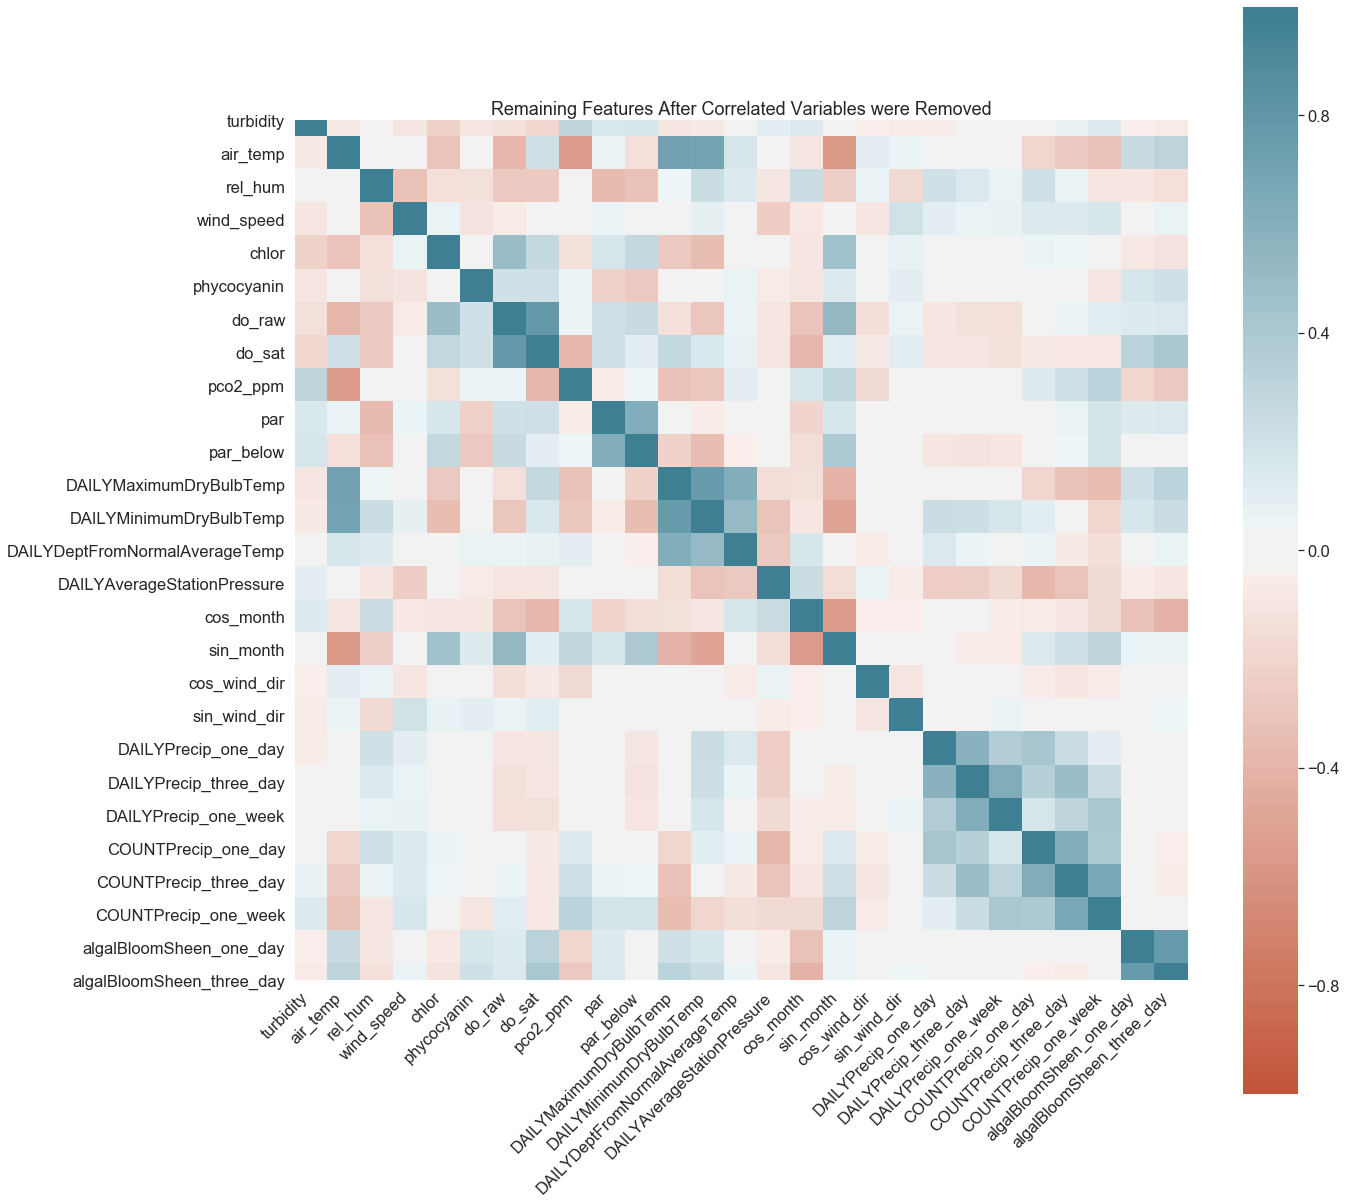

In [5]:
corr_thresh = 0.80  # threshold for correlation. for any two variables with correlation > thresh, one is removed

thresh = corr.abs() > corr_thresh

keep = copy.deepcopy(data.columns).to_list()

print('Removed features: ')
# keep features whose correlation with other features is <= corr_thresh
for i in range(0, len(thresh.index)):
    for j in range(i+1, len(thresh.columns)):
        if thresh.iloc[i, j]:
            if thresh.columns[j] in keep:
                print('\t', thresh.columns[j])
                keep.remove(thresh.columns[j])

new_corr = data[keep].corr()
plt.subplots(figsize=(20, 20))
sns.set(font_scale=1.5)

ax = sns.heatmap(
    new_corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_title('Remaining Features After Correlated Variables were Removed');

### Split Data

In [28]:
train_test_size = 0.8
train_size = 0.625
data_aug = False
batch_size = 16
rand_state=123

df = data[keep]
# df = df[df.index > '2016']   # only keep data after 2015
# labels = labels.loc[df.index]

train_test_idx, hold_idx, y_train_test, y_hold = train_test_split(
    np.arange(len(df)),
    labels.values.ravel(),
    train_size=train_test_size,
    shuffle=True,
    stratify=labels.values.ravel(),
    random_state=rand_state
)

X_train_test = df.iloc[train_test_idx].values
X_hold = df.iloc[hold_idx].values

train_idx, test_idx, y_train, y_test = train_test_split(
    train_test_idx,
    y_train_test,
    train_size=train_size,
    shuffle=True,
    stratify=y_train_test,
    random_state=rand_state
)

X_train = df.iloc[train_idx].values
X_test = df.iloc[test_idx].values

# X_train_test, X_hold, y_train_test, y_hold = train_test_split(
#     df.values,
#     labels.values.ravel(),
#     train_size=train_size,
#     shuffle=True,
#     stratify=labels.values.ravel(),
#     random_state=1337
# )

# X_train, X_test, y_train, y_test = train_test_split(
#     X_train_test,
#     y_train_test,
#     train_size=train_size,
#     shuffle=True,
#     stratify=y_train_test,
#     random_state=1337
# )

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_hold = scaler.transform(X_hold)

## Logistic Regression

### Define Model

In [29]:
log = LogisticRegression(
    penalty='l1',
    tol=0.0001,
    C=1,
    fit_intercept=True,
    class_weight='balanced',
    solver='liblinear'
)

## Evaluate

Accuracy: 0.7277
Balanced Accuracy: 0.7277
F1 Score: 0.6176

Confusion Matrix:


,0,1
0,97,31
1,21,42


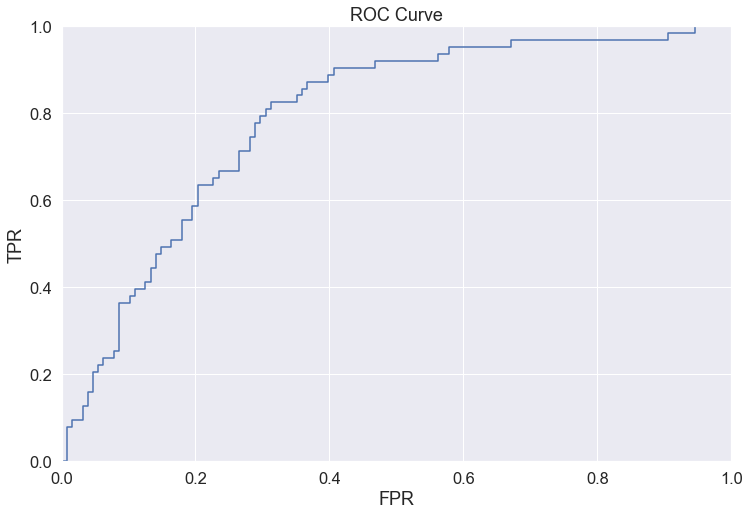

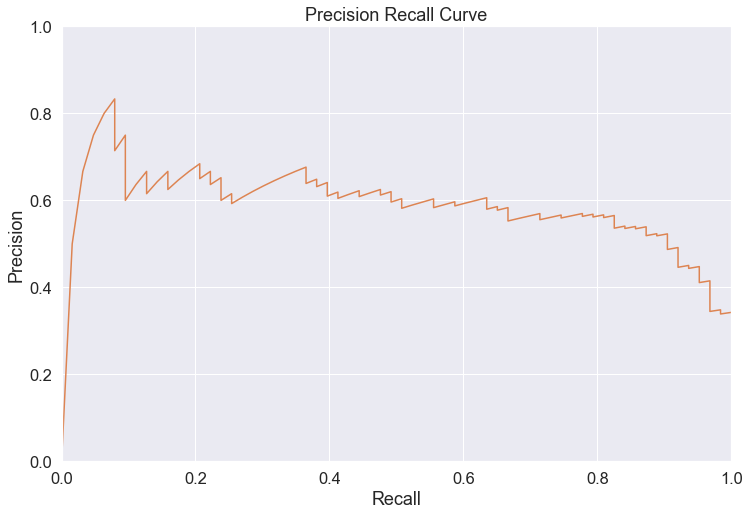

In [30]:
log.fit(X_train, y_train)
log_y_pred = log.predict(X_test)
log_y_prob = log.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, log_y_pred)
balanced_acc = accuracy_score(y_test, log_y_pred)
f1 = f1_score(y_test, log_y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, log_y_pred))
fpr, tpr, _ = roc_curve(y_test, log_y_prob)
precision, recall, _ = precision_recall_curve(y_test, log_y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

In [31]:
coef_sort_idx = np.argsort(-np.abs(log.coef_[0]), kind='mergesort')

print('Feature weighting for logistic regression\n')
for idx in coef_sort_idx:
    coef = log.coef_[0][idx]
    
    if coef < 0:
        print('\t%0.4f' % log.coef_[0][idx], df.columns[idx])
    else:
        print('\t %0.4f' % log.coef_[0][idx], df.columns[idx])

Feature weighting for logistic regression

	-1.0141 do_raw
	 0.9730 do_sat
	 0.6718 sin_month
	-0.6536 pco2_ppm
	 0.5189 algalBloomSheen_three_day
	 0.4723 algalBloomSheen_one_day
	 0.3650 DAILYMinimumDryBulbTemp
	-0.2884 DAILYPrecip_three_day
	 0.1764 DAILYAverageStationPressure
	 0.1510 DAILYPrecip_one_day
	 0.1437 turbidity
	 0.1238 DAILYPrecip_one_week
	-0.0960 wind_speed
	-0.0942 par
	-0.0735 COUNTPrecip_three_day
	-0.0648 phycocyanin
	-0.0582 cos_month
	-0.0570 COUNTPrecip_one_day
	-0.0539 DAILYMaximumDryBulbTemp
	-0.0503 cos_wind_dir
	-0.0198 sin_wind_dir
	-0.0192 rel_hum
	 0.0069 par_below
	 0.0000 air_temp
	 0.0000 chlor
	 0.0000 DAILYDeptFromNormalAverageTemp
	 0.0000 COUNTPrecip_one_week


## Random Forest Classifer

### Define Model

In [32]:
rfc = RandomForestClassifier(
    n_estimators=1000,
    max_depth=4,
    criterion='gini',
    bootstrap=True,
    class_weight='balanced'
)

### Evaluate

Accuracy: 0.7644
Balanced Accuracy: 0.7644
F1 Score: 0.6512

Confusion Matrix:


,0,1
0,104,24
1,21,42


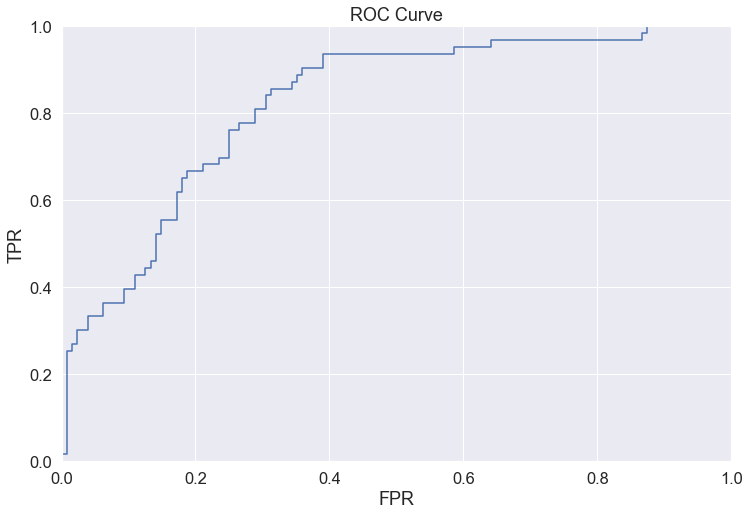

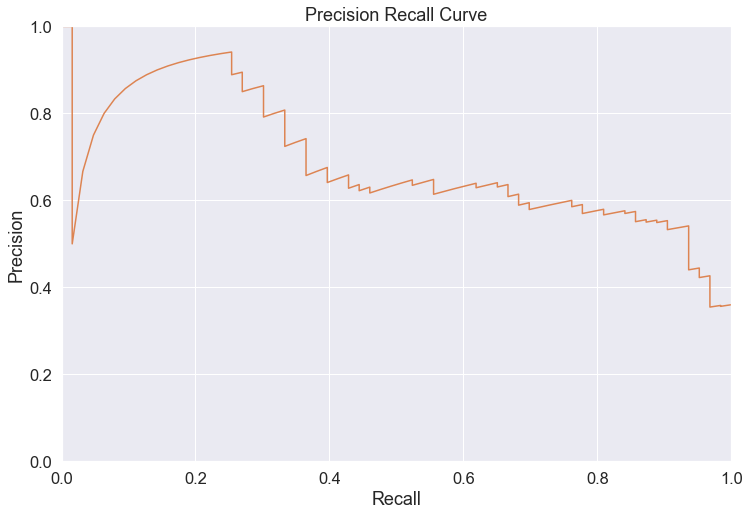

In [33]:
rfc.fit(X_train, y_train)
rfc_y_pred = rfc.predict(X_test)
rfc_y_prob = rfc.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, rfc_y_pred)
balanced_acc = accuracy_score(y_test, rfc_y_pred)
f1 = f1_score(y_test, rfc_y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, rfc_y_pred))
fpr, tpr, _ = roc_curve(y_test, rfc_y_prob)
precision, recall, _ = precision_recall_curve(y_test, rfc_y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

In [34]:
coef_sort_idx = np.argsort(-np.abs(rfc.feature_importances_), kind='mergesort')

print('Feature weighting for Decision Trees with AdaBoost\n')
for idx in coef_sort_idx:
    coef = rfc.feature_importances_[idx]
    
    if coef < 0:
        print('\t%0.4f' % rfc.feature_importances_[idx], df.columns[idx])
    else:
        print('\t %0.4f' % rfc.feature_importances_[idx], df.columns[idx])

Feature weighting for Decision Trees with AdaBoost

	 0.1504 algalBloomSheen_one_day
	 0.1308 algalBloomSheen_three_day
	 0.0593 pco2_ppm
	 0.0572 do_sat
	 0.0539 phycocyanin
	 0.0513 cos_month
	 0.0511 air_temp
	 0.0471 chlor
	 0.0429 do_raw
	 0.0417 turbidity
	 0.0356 DAILYMinimumDryBulbTemp
	 0.0283 cos_wind_dir
	 0.0273 DAILYPrecip_one_week
	 0.0265 DAILYDeptFromNormalAverageTemp
	 0.0250 DAILYMaximumDryBulbTemp
	 0.0234 sin_month
	 0.0221 wind_speed
	 0.0203 par_below
	 0.0200 rel_hum
	 0.0183 sin_wind_dir
	 0.0182 par
	 0.0175 DAILYAverageStationPressure
	 0.0143 DAILYPrecip_three_day
	 0.0077 COUNTPrecip_one_week
	 0.0061 DAILYPrecip_one_day
	 0.0027 COUNTPrecip_three_day
	 0.0011 COUNTPrecip_one_day


## K-Nearest Neighbors

### Define Model

In [35]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    weights='uniform',    # or distance
    p=2
)

### Evaluate

Accuracy: 0.7644
Balanced Accuracy: 0.7644
F1 Score: 0.6512

Confusion Matrix:


,0,1
0,104,24
1,21,42


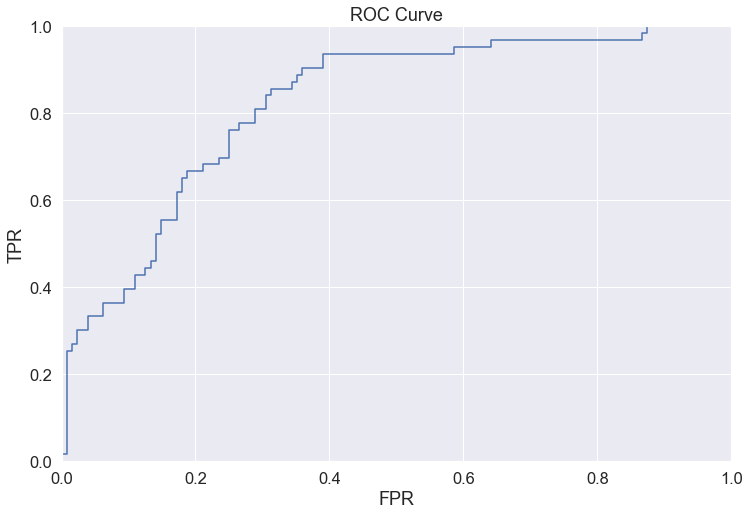

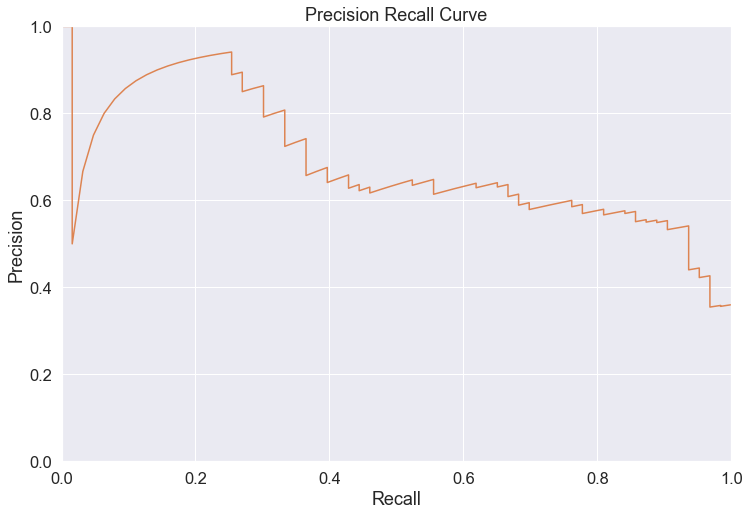

In [36]:
knn.fit(X_train, y_train)
knn_y_pred = rfc.predict(X_test)
knn_y_prob = rfc.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, knn_y_pred)
balanced_acc = accuracy_score(y_test, knn_y_pred)
f1 = f1_score(y_test, knn_y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_test, knn_y_pred))
fpr, tpr, _ = roc_curve(y_test, knn_y_prob)
precision, recall, _ = precision_recall_curve(y_test, knn_y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');

## ResNet

## Create Data Loaders

In [37]:
class AlgalBloomDataset(data_utils.Dataset):

    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): numpy array of data samples
            labels (numpy array): numpy array of labels for the data samples
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.fromarray(self.data[idx])
        target = self.labels[idx]
        
        if self.transform:
            img = self.transform(img)

        return img, target

In [38]:
batch_size = 16
data_aug = False    # data augmentation

# zero pad data set. The input format for the resnet must be 5x5, or 6x6, or 7x7, etc.
pad_df = copy.deepcopy(df)
for i in range(36-df.shape[1]):
    pad_df[i] = [1 for _ in range(df.shape[0])]

vals = pad_df.values
data_reshape = []
for i in range(pad_df.shape[0]):
    # add rotated versions of the input to different channels
    data_reshape.append(vals[i].reshape(6, 6))
    
# Stratified split into training and holdout set
# X_train_test_res, X_hold_res, y_train_test_res, y_hold_res = train_test_split(
#     data_reshape,
#     labels.values.ravel(),
#     train_size=train_test_size,
#     shuffle=True,
#     stratify=labels.values.ravel(),
#     random_state=1337
# )

# X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
#     X_train_test_res,
#     y_train_test_res,
#     train_size=train_size,
#     shuffle=True,
#     stratify=y_train_test_res,
#     random_state=1337
# )

X_train_res = np.asarray(data_reshape)[train_idx]
X_test_res = np.asarray(data_reshape)[test_idx]
X_hold_res = np.asarray(data_reshape)[hold_idx]

print('Training set size:', X_train_res.shape)
print('Testing set size:', X_test_res.shape)
print('Holdout set size:', X_hold_res.shape)

if data_aug:
    trnsfrm = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]),
    ])
else:
    trnsfrm = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]),
    ])

train_set = AlgalBloomDataset(X_train_res, y_train, trnsfrm)

test_set = AlgalBloomDataset(X_test_res, y_test, 
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]),
    ])
)

hold_set = AlgalBloomDataset(X_hold_res, y_hold, 
    transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]),
    ])
)

train_loader = data_utils.DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = data_utils.DataLoader(test_set, batch_size=len(test_set), shuffle=False)
hold_loader = data_utils.DataLoader(hold_set, batch_size=len(hold_set), shuffle=False)

# this data loader is used to get the indices of misclassified examples
missed_test_loader = data_utils.DataLoader(test_set, batch_size=1, shuffle=False)

Training set size: (317, 6, 6)
Testing set size: (191, 6, 6)
Holdout set size: (128, 6, 6)


### Define ResNet Model

In [39]:
learning_rate = 0.1
num_epochs = 5
weighted = True

if weighted:
    class_weights = torch.Tensor([np.bincount(y_train.astype(int))[0] / len(y_train), 
                                  np.bincount(y_train.astype(int))[1] / len(y_train)])
else:
    class_weights=None

model = resnet.ResNet9()
criterion = nn.CrossEntropyLoss(weight=class_weights)
opt = optim.SGD(model.parameters(), lr=learning_rate, nesterov=False, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(opt, milestones=[50, 100, 150, 200], gamma=0.1)

### Train ResNet

In [40]:
model.train()   # train model

loss_arr = []
acc_arr = []
f1_arr = []

for epoch in range(num_epochs):    
    print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
    print('-' * 10)
    
    epoch_loss_arr = []
    epoch_acc_arr = []
    epoch_f1_arr = []
    
    for samples, target in train_loader:
        opt.zero_grad()
        output = model(samples)
        loss = criterion(output, target)
        
        _, pred = torch.max(output, 1)
                
        loss.backward()
        opt.step()
        
        epoch_loss_arr.append(loss.item())
        epoch_acc_arr.append(torch.sum(pred == target).float() / len(target))
        epoch_f1_arr.append(f1_score(target, pred))
    
    epoch_loss = sum(epoch_loss_arr)
    epoch_acc = sum(epoch_acc_arr) / len(epoch_acc_arr)
    epoch_f1 = sum(epoch_f1_arr) / len(epoch_f1_arr)
    
    loss_arr.append(epoch_loss)
    acc_arr.append(epoch_acc)
    f1_arr.append(epoch_f1)
    
    print('Loss: {:0.4f} Acc: {:0.4f} F1: {:0.4f}\n'.format(epoch_loss, epoch_acc, epoch_f1))
    
    scheduler.step()


Epoch 1/5
----------
Loss: 16.4088 Acc: 0.6447 F1: 0.0736


Epoch 2/5
----------
Loss: 50.6666 Acc: 0.6392 F1: 0.0538


Epoch 3/5
----------
Loss: 30.3370 Acc: 0.6572 F1: 0.1196


Epoch 4/5
----------
Loss: 10.7402 Acc: 0.6579 F1: 0.0000


Epoch 5/5
----------
Loss: 10.5754 Acc: 0.6517 F1: 0.0518



### Plot Training Performance

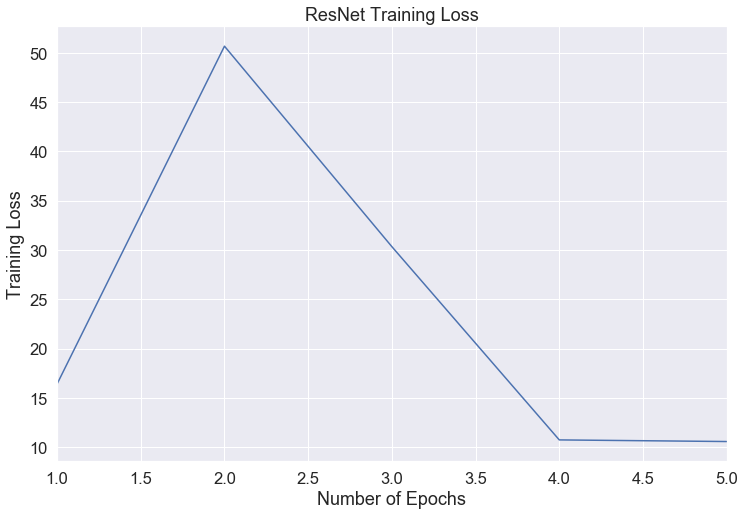

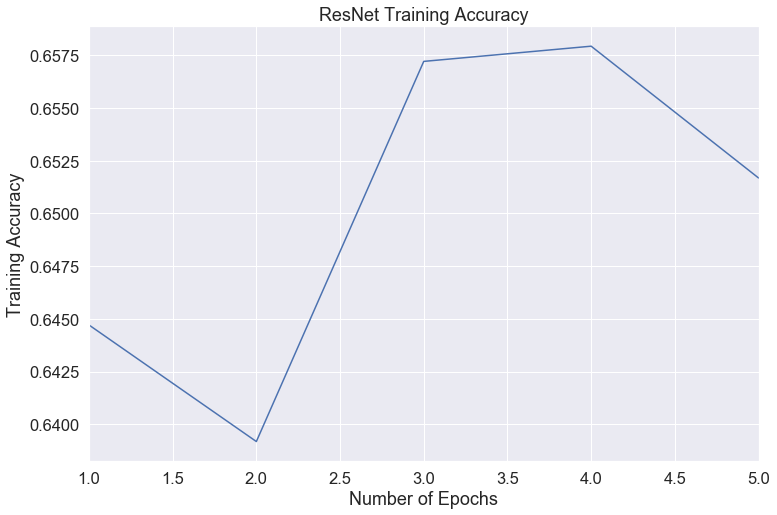

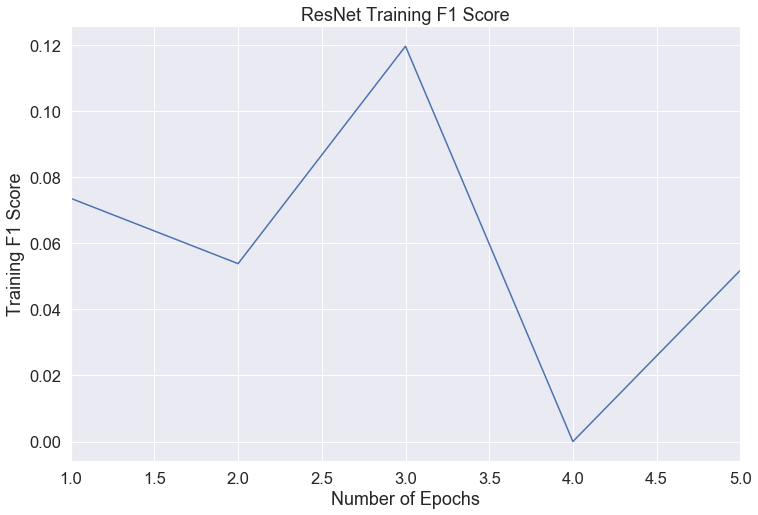

In [41]:
x = [i for i in range(1, num_epochs+1)]

plt.figure(figsize=(12, 8))
plt.plot(x, loss_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.title('ResNet Training Loss')
plt.xlim([1, num_epochs])
plt.grid(True)

plt.figure(figsize=(12, 8))
plt.plot(x, acc_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Accuracy')
plt.title('ResNet Training Accuracy')
plt.xlim([1, num_epochs])
plt.grid(True)

plt.figure(figsize=(12, 8))
plt.plot(x, f1_arr)
plt.xlabel('Number of Epochs')
plt.ylabel('Training F1 Score')
plt.title('ResNet Training F1 Score')
plt.xlim([1, num_epochs])
plt.grid(True)

### Test ResNet

In [42]:
model.eval()    # test model

for samples, target in test_loader:
    opt.zero_grad()
    output = model(samples)
    loss = criterion(output, target)

    res_y_prob, pred = torch.max(nn.functional.softmax(output, 1), 1)

res_y_prob = res_y_prob.data.numpy()
    
acc = torch.sum(pred == target).float() / len(target)
f1 = f1_score(target, pred)
conf_matrix = confusion_matrix(target.numpy(), pred.numpy(), labels=[0, 1])

print('\nTest Accuracy: {:0.4f}'.format(acc))
print('\nF1 Score: {:0.4f}'.format(f1))
print('Confusion Matrix:')
display(pd.DataFrame(conf_matrix))

res_missed_idx = []
idx = 0

for samples, target in missed_test_loader:
    output = model(samples)
    loss = criterion(output, target)

    _, pred = torch.max(output, 1)
    
    if pred != target:
        res_missed_idx.append(idx)
        
    idx += 1


Test Accuracy: 0.6702

F1 Score: 0.0000
Confusion Matrix:


,0,1
0,128,0
1,63,0


## Determine Misclassifications for Logistic Regression and Random Forest

In [43]:
log_missed_idx = np.where(log_y_pred != y_test)[0]   # index of misclassifications for logistic regression
rfc_missed_idx = np.where(rfc_y_pred != y_test)[0]   # index of misclassifications for random forest
knn_missed_idx = np.where(knn_y_pred != y_test)[0]   # index of misclassifications for k nearest neighbors

# count overlapping misclassifications and show dataframe of the instances
missed_idx = [log_missed_idx, res_missed_idx] #knn_missed_idx] #rfc_missed_idx]

if len(missed_idx[0]) <= len(missed_idx[1]):
    iter_idx = 0     # choose to itrate over the shorter of the two arrays
else:
    iter_idx = 1

overlap_idx = []

for i in range(len(missed_idx[iter_idx])):
    if missed_idx[iter_idx][i] in missed_idx[(len(missed_idx)-1)-iter_idx]:
        overlap_idx.append(missed_idx[iter_idx][i])

print(len(overlap_idx), 'out of', len(missed_idx[(len(missed_idx)-1)-iter_idx]), 
    'misclassifications were overlapped between logistic regression and ResNet9\n\n')

missed_df = pd.DataFrame(X_test[overlap_idx], columns=df.columns)
missed_df.insert(loc=0, column='labels', value=y_test[overlap_idx])

# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(missed_df)

21 out of 63 misclassifications were overlapped between logistic regression and ResNet9




## Stacking

### Create Training Set for Meta-Learner

In [44]:
X_train_meta = np.hstack((
    log_y_prob.reshape(len(log_y_prob), 1),
    res_y_prob.reshape(len(res_y_prob), 1)
))
y_train_meta = y_test

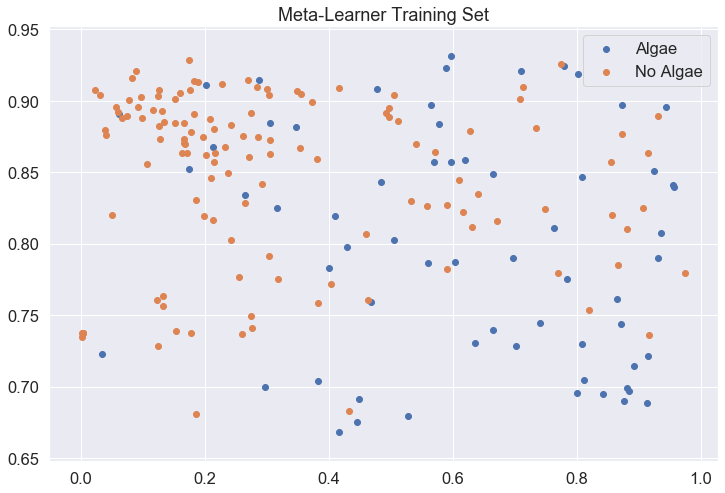

In [45]:
pos = []
neg = []

for i in range(len(y_train_meta)):
    if y_train_meta[i] > 0:
        pos.append(X_train_meta[i, :])
    else:
        neg.append(X_train_meta[i, :])
        
pos = np.asarray(pos)
neg = np.asarray(neg)

plt.figure(figsize=(12, 8))
plt.scatter(pos[:, 0], pos[:, 1], label='Algae')
plt.scatter(neg[:, 0], neg[:, 1], label='No Algae')
plt.title('Meta-Learner Training Set')
plt.legend(loc='best')
plt.grid(True)

### Define Meta-Learner

In [46]:
meta = LogisticRegression(
    penalty='l1',
    tol=0.0001,
    C=1,
    fit_intercept=True,
    class_weight='balanced',
    solver='liblinear'
)

### Evaluate

In [47]:
log_y_hold_pred = log.predict(X_hold)
log_y_hold_prob = log.predict_proba(X_hold)[:, 1]

for samples, target in hold_loader:
    output = model(samples)
    loss = criterion(output, target)

    res_y_hold_prob, pred = torch.max(nn.functional.softmax(output, 1), 1)

res_y_hold_prob = res_y_hold_prob.data.numpy()

X_hold_meta = np.hstack((
    log_y_hold_prob.reshape(len(log_y_hold_prob), 1),
    res_y_hold_prob.reshape(len(res_y_hold_prob), 1)
))
y_hold_meta = y_hold

Accuracy: 0.7578
Balanced Accuracy: 0.7578
F1 Score: 0.6593

Confusion Matrix:


,0,1
0,67,19
1,12,30


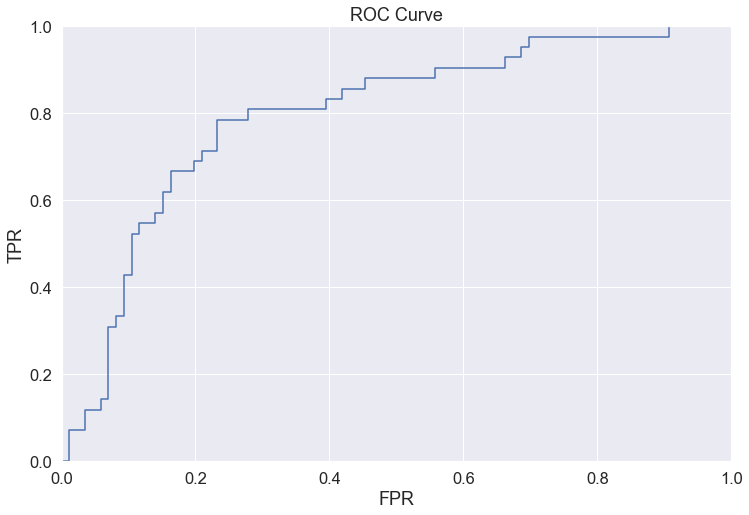

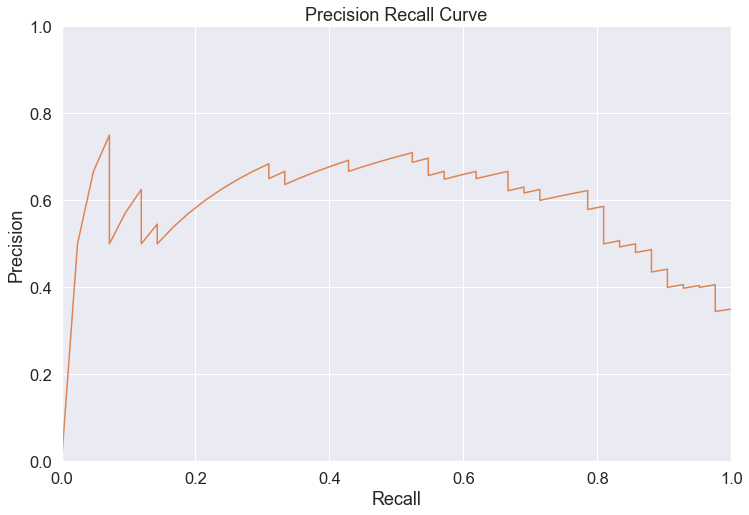

In [48]:
meta.fit(X_train_meta, y_train_meta)
meta_y_pred = meta.predict(X_hold_meta)
meta_y_prob = meta.predict_proba(X_hold_meta)[:, 1]

acc = accuracy_score(y_hold, meta_y_pred)
balanced_acc = accuracy_score(y_hold, meta_y_pred)
f1 = f1_score(y_hold, meta_y_pred)
conf_matrix = pd.DataFrame(confusion_matrix(y_hold, meta_y_pred))
fpr, tpr, _ = roc_curve(y_hold, meta_y_prob)
precision, recall, _ = precision_recall_curve(y_hold, meta_y_prob)

print('Accuracy: %0.4f' % acc)
print('Balanced Accuracy: %0.4f' % balanced_acc)
print('F1 Score: %0.4f' % f1)
print('\nConfusion Matrix:')
display(conf_matrix)  # rows are the true label, columns are the predicted label ([0,1] is FP, [1,0] is FN)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, c='C0')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('ROC Curve')

plt.figure(figsize=(12, 8))
plt.plot(recall, precision, c='C1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.axis([0, 1, 0, 1])
plt.grid(True)
plt.title('Precision Recall Curve');